In [1]:
"""
GPX-Track Visualisierung mit OSM-Daten

Dieses Skript liest eine GPX-Datei und visualisiert den Track auf einer Karte, wobei OSM-Daten für das Straßennetz sowie optional ein zusätzliches Shapefile (z. B. Gewässer) als Hintergrund genutzt werden. Es werden außerdem die Gesamtstrecke und die verstrichene Zeit des Tracks berechnet und in der Grafik angezeigt.

Funktionen:
- Einlesen einer GPX-Datei und Extraktion von GPS-Daten (Breitengrad, Längengrad, Zeitstempel)
- Berechnung der Bounding-Box basierend auf den GPS-Daten mit optionalem Puffer
- Herunterladen des Straßennetzes aus OpenStreetMap mit Hilfe von OSMnx
- Berechnung der zurückgelegten Distanz und der verstrichenen Zeit
- Visualisierung des Tracks zusammen mit dem Straßennetz und optional einem Shapefile
- Anzeige von Distanz, Zeit und Datum im oberen rechten Bereich der Grafik
- Export der Grafik als PNG-Datei

Parameter:
- `gpx_file_path`: Der Pfad zur GPX-Datei.
- `shapefile_path`: Der Pfad zum zusätzlichen Shapefile (z.B. Gewässer).
- `padding`: Pufferwert für die Bounding-Box.
- `titel`: Titel für den Plot und Dateinamen.
- `infotext`: Boolescher Wert, der bestimmt, ob Infos wie Distanz und Dauer angezeigt werden.
- `addShapefile`: Boolescher Wert, der angibt, ob ein zusätzliches Shapefile geladen werden soll.

Voraussetzungen:
- `gpxpy`: Zum Parsen von GPX-Dateien
- `matplotlib`: Zum Erstellen der Visualisierung
- `osmnx`: Zum Laden und Visualisieren von OpenStreetMap-Daten
- `geopy`: Für die Berechnung der Distanz zwischen den GPX-Punkten
- `geopandas`: Für das Laden und Visualisieren von Shapefiles

Verwendung:
1. Setze den Pfad zur GPX-Datei (`gpx_file_path`) und optional zum Shapefile (`shapefile_path`).
2. Führe das Skript aus, um den Track zu visualisieren und als PNG-Datei zu speichern.
3. Die Grafik zeigt den GPX-Track auf einer Karte zusammen mit den relevanten Informationen.

"""

'\nGPX-Track Visualisierung mit OSM-Daten\n\nDieses Skript liest eine GPX-Datei und visualisiert den Track auf einer Karte, wobei OSM-Daten für das Straßennetz sowie optional ein zusätzliches Shapefile (z. B. Gewässer) als Hintergrund genutzt werden. Es werden außerdem die Gesamtstrecke und die verstrichene Zeit des Tracks berechnet und in der Grafik angezeigt.\n\nFunktionen:\n- Einlesen einer GPX-Datei und Extraktion von GPS-Daten (Breitengrad, Längengrad, Zeitstempel)\n- Berechnung der Bounding-Box basierend auf den GPS-Daten mit optionalem Puffer\n- Herunterladen des Straßennetzes aus OpenStreetMap mit Hilfe von OSMnx\n- Berechnung der zurückgelegten Distanz und der verstrichenen Zeit\n- Visualisierung des Tracks zusammen mit dem Straßennetz und optional einem Shapefile\n- Anzeige von Distanz, Zeit und Datum im oberen rechten Bereich der Grafik\n- Export der Grafik als PNG-Datei\n\nParameter:\n- `gpx_file_path`: Der Pfad zur GPX-Datei.\n- `shapefile_path`: Der Pfad zum zusätzlichen 

In [28]:
import os
import gpxpy
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from geopy.distance import geodesic
from datetime import timedelta
from datetime import datetime

Keine (oder zu wenige) gültige Zeitstempel. Überspringe Zeit-Berechnungen.


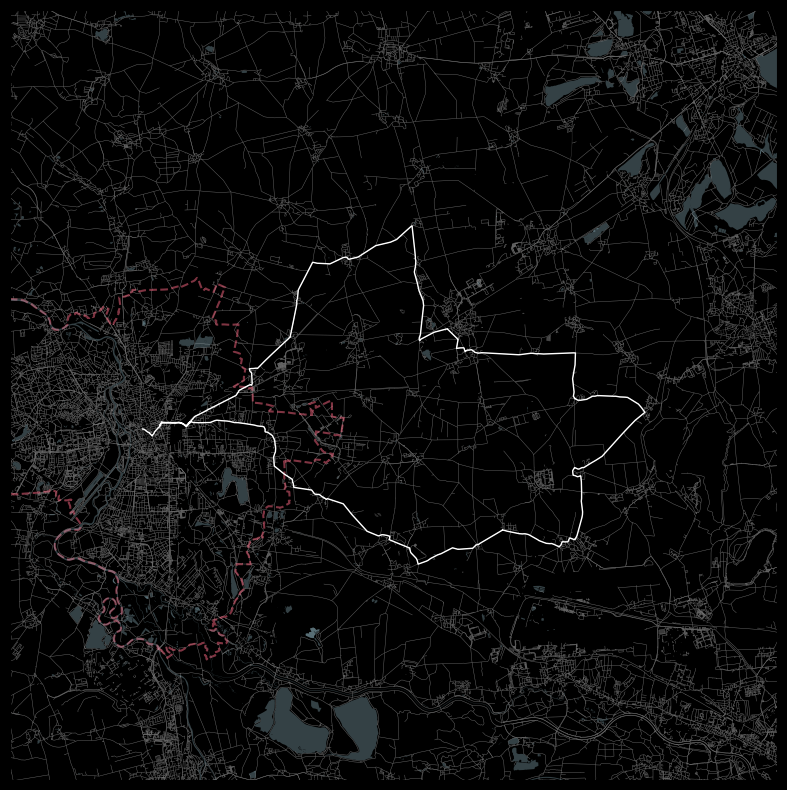

Bild gespeichert als: ../data/export/01_single_track_2025-04-04_10-18-44.png
VCA Frühjahrsklassiker
Datum Unbekannt
Distanz: 62.88 km
Dauer: Keine Zeitdaten


In [23]:
# black //road

gpx_file_path = "../data/sample_gpx/Halle-Koelsa-Halle.gpx"  # Ersetze mit deinem GPX-Dateipfad
shapefile_path = "../data/plot_data/gis_osm_water_a_free_1.shp"  # Ersetze mit deinem Shapefile-Pfad
halle = gpd.read_file("../data/plot_data/halle.geojson")

#padding für Puffer um GPX definieren, Standart 0.01 - für quadratische Ausgabe höher wählen und dann zuschneiden
padding = 0.08
#titel für Plot und Dateinamen definieren
titel = "VCA Frühjahrsklassiker"
#Infotext = True zeichnet Text mit Infos zur GPX
infotext = False
# Zusätzliches Shapefile z.B. Gewässer OSM laden
addShapefile = True

# GPX-Datei einlesen
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# GPX-Daten extrahieren (Latitude, Longitude, Zeit)
lats, lons, times = [], [], []

# Tracks und Segmente durchlaufen
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            times.append(point.time)

# Berechnung des Bounding-Boxes für den GPX-Track
north, south, east, west = max(lats), min(lats), max(lons), min(lons)
#padding = Puffer um den Track
north += padding
south -= padding
east += padding
west -= padding

# Bounding-Box erstellen
bbox = (west, south, east, north)  # (left, bottom, right, top)

# Herunterladen des Straßennetzes mit osmnx
G = ox.graph_from_bbox(
    bbox=bbox,
    network_type="bike",
    simplify=True,
    retain_all=True,
    truncate_by_edge=True,
)

# Kanten des Netzwerks extrahieren
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Distanz berechnen
distance_km = sum(
    geodesic((lats[i], lons[i]), (lats[i + 1], lons[i + 1])).km
    for i in range(len(lats) - 1)
)

# Zeitstempel filtern
valid_times = [t for t in times if t is not None]

if len(valid_times) < 2:
    print("Keine (oder zu wenige) gültige Zeitstempel. Überspringe Zeit-Berechnungen.")
    elapsed_time_str = "Keine Zeitdaten"
    start_date = "Unbekannt"
else:
    # Verstrichene Zeit berechnen
    elapsed_time = valid_times[-1] - valid_times[0]
    elapsed_time_str = str(elapsed_time).split('.')[0]
    # Datum des ersten Zeitstempels
    start_date = valid_times[0].strftime("%d.%m.%Y")
    print(f"Verstrichene Zeit: {elapsed_time_str}, Startdatum: {start_date}")



# Visualisierung mit matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Straßennetz als Hintergrund zeichnen
edges.plot(ax=ax, linewidth=0.3, color="gray", alpha=0.5, zorder=1)

# GPX-Track zeichnen
ax.plot(lons, lats, color="white", linewidth=1, zorder=3)
halle.plot(ax=ax, linewidth=1.5, color="#FF6984",linestyle='--', alpha=0.5, zorder=2)

if addShapefile:
    shapefile = gpd.read_file(shapefile_path)

    # Optional: Falls du bestimmte Farben und Stile für das Shapefile festlegen möchtest:
    #shapefile.plot(ax=ax, color="grey", alpha=1, linewidth=2, zorder=10)
    shapefile.plot(ax=ax, color="lightblue", alpha=0.3, linewidth=2, zorder=2)

# Text mit Distanz und Zeit hinzufügen

if infotext:
    text_info = (
        f"{titel}\n"
        f"{start_date}\n"
        f"Distanz: {distance_km:.2f} km\n"
        f"Dauer: {elapsed_time_str}"
    )
    
    # Fügt einen Text in die obere rechte Ecke der Achse ein.
    # Optionen:
    # - transform=ax.transAxes: Position relativ zur Achse (0-1, unabhängig von Datenwerten).
    # - color="white": Weißer Text.
    # - fontsize=12: Schriftgröße in Punkten.
    # - ha="right": Text endet rechts von der angegebenen Position (x=0.98).
    # - va="top": Text endet oberhalb der angegebenen Position (y=0.98).
    
    ax.text(
        0.98, 0.98, text_info, 
        transform=ax.transAxes, 
        color="white", 
        fontsize=12, 
        ha="right", 
        va="top"
    )


# Hintergrund schwarz setzen
ax.set_facecolor("black")
fig.patch.set_facecolor("black")

# Achsen entfernen
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([west, east])
ax.set_ylim([south, north])

# Legende hinzufügen
#ax.legend(loc="lower left", fontsize=10, facecolor="black", edgecolor="white", labelcolor="white")


# Plot anzeigen
plt.show()

# Generiere den Zeitstempel im Format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


output_directory = "../data/export/"
output_filename = os.path.join(output_directory, f"01_single_track_{timestamp}.png")


# Dateiname mit Zeitstempel
#output_filename = f"{titel}_{timestamp}_gpx_track_plot.png"

# Speichern der Grafik mit dem neuen Dateinamen
fig.savefig(output_filename, dpi=1080, bbox_inches="tight", facecolor="black")
print(f"Bild gespeichert als: {output_filename}")


print(f"{titel}")
print(f"Datum {start_date}")
print(f"Distanz: {distance_km:.2f} km")
print(f"Dauer: {elapsed_time_str}")

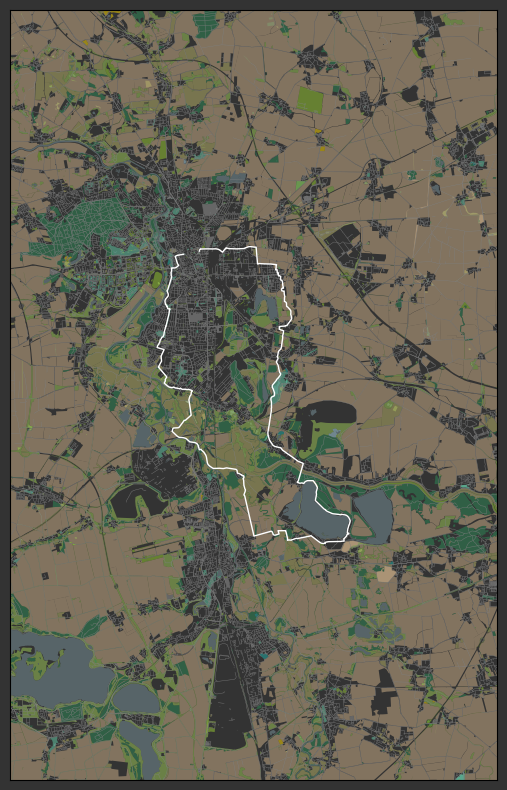

Bild gespeichert als: ../data/export/01_single_track_2025-04-19_18-33-42.png


In [41]:
# Schotterbande

gpx_file_path = "../data/sample_gpx/VCA_CX.gpx"  # Ersetze mit deinem GPX-Dateipfad
water_path = "../data/plot_data/gis_osm_water_a_free_1.shp"  # Ersetze mit deinem Shapefile-Pfad
halle = gpd.read_file("../data/plot_data/halle.geojson")
osm_landuse = gpd.read_file("../data/plot_data/osm_landuse.geojson")

# Farbzuordnung für bestimmte fclass-Werte
color_map = {
    'forest': '#2E8B57',
    'farmland': '#D2B48C',
    'grass': '#9ACD32',
    'meadow': '#BDB76B',
    'scrub': '#A2CD5A',
    'park': '#66CDAA',
    'recreation_ground': '#20B2AA',
    'orchard': '#FFD700',
    'vineyard': '#8B4513',
    'cemetery': '#999999'
}

# Neue Spalte mit Farben – alle anderen werden NaN (unsichtbar)
osm_landuse['fill_color'] = osm_landuse['fclass'].map(color_map)

# Nur sichtbare Flächen behalten (nur definierte Farben)
osm_landuse_colored = osm_landuse[~osm_landuse['fill_color'].isna()]

#padding für Puffer um GPX definieren, Standart 0.01 - für quadratische Ausgabe höher wählen und dann zuschneiden
padding = 0.1
# Zusätzliches Shapefile z.B. Gewässer OSM laden
addShapefile = True

# GPX-Datei einlesen
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# GPX-Daten extrahieren (Latitude, Longitude, Zeit)
lats, lons, times = [], [], []

# Tracks und Segmente durchlaufen
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            times.append(point.time)

# Berechnung des Bounding-Boxes für den GPX-Track
north, south, east, west = max(lats), min(lats), max(lons), min(lons)
#padding = Puffer um den Track
north += padding
south -= padding
east += padding
west -= padding

# Bounding-Box erstellen
bbox = (west, south, east, north)  # (left, bottom, right, top)

# Herunterladen des Straßennetzes mit osmnx
G = ox.graph_from_bbox(
    bbox=bbox,
    network_type="bike",
    simplify=True,
    retain_all=True,
    truncate_by_edge=True,
)

# Kanten des Netzwerks extrahieren
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Distanz berechnen
distance_km = sum(
    geodesic((lats[i], lons[i]), (lats[i + 1], lons[i + 1])).km
    for i in range(len(lats) - 1)
)

# Visualisierung mit matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Straßennetz als Hintergrund zeichnen
edges.plot(ax=ax, linewidth=0.3, color="gray", alpha=0.5, zorder=2)

# GPX-Track zeichnen
ax.plot(lons, lats, color="white", linewidth=1, zorder=3)
#halle.plot(ax=ax, linewidth=1.5, color="#FF6984",linestyle='--', alpha=1, zorder=1)

if addShapefile:
    water = gpd.read_file(water_path)

    # Optional: Falls du bestimmte Farben und Stile für das Shapefile festlegen möchtest:
    #shapefile.plot(ax=ax, color="grey", alpha=1, linewidth=2, zorder=10)
    water.plot(ax=ax, color="lightblue", alpha=0.3, linewidth=2, zorder=1)

osm_landuse_colored.plot(ax=ax, color=osm_landuse_colored['fill_color'], edgecolor='none', linewidth=0.2, alpha=0.5, zorder=1)

# Hintergrund setzen
ax.set_facecolor("#333333")
fig.patch.set_facecolor("#333333")

# Achsen entfernen
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([west, east])
ax.set_ylim([south, north])

# Plot anzeigen
plt.show()

# Generiere den Zeitstempel im Format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


output_directory = "../data/export/"
output_filename = os.path.join(output_directory, f"01_single_track_{timestamp}.png")

# Speichern der Grafik mit dem neuen Dateinamen
fig.savefig(output_filename, dpi=1080, bbox_inches="tight", facecolor="black")
print(f"Bild gespeichert als: {output_filename}")

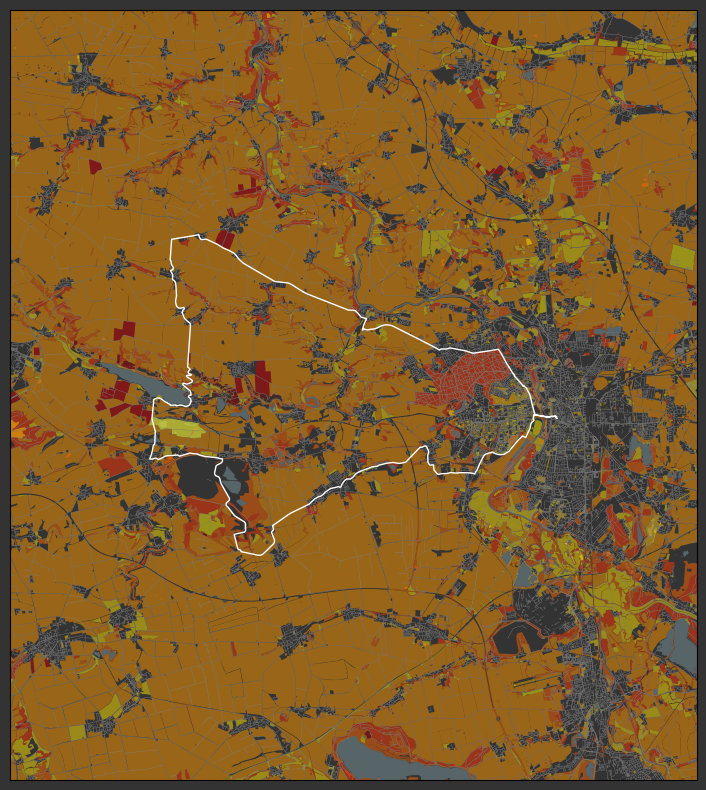

Bild gespeichert als: ../data/export/01_single_track_2025-04-14_11-59-44.png


In [30]:
# Temporunde

gpx_file_path = "../data/sample_gpx/VCA_TR.gpx"  # Ersetze mit deinem GPX-Dateipfad
water_path = "../data/plot_data/gis_osm_water_a_free_1.shp"  # Ersetze mit deinem Shapefile-Pfad
halle = gpd.read_file("../data/plot_data/halle.geojson")
osm_landuse = gpd.read_file("../data/plot_data/osm_landuse.geojson")

# Farbzuordnung für bestimmte fclass-Werte
color_map = {
    'grass':     '#fff200',  # helles Neongelb – offen, dynamisch
    'meadow':    '#ffe100',  # sattes Gelb
    'park':      '#ffc000',  # gold-orange
    'farmland':  '#ff9900',  # kräftiges Orange
    'scrub':     '#ff6600',  # tieferes Orange, Richtung rot
    'forest':    '#ff3300',  # leuchtendes Rot – dichter Wald, höhere Intensität
    'orchard':   '#cc0000',  # dunkles Kirschrot – kultiviert, aber intensiv
    'vineyard':  '#990000',  # tiefrot, zurückhaltend
}

# Neue Spalte mit Farben – alle anderen werden NaN (unsichtbar)
osm_landuse['fill_color'] = osm_landuse['fclass'].map(color_map)

# Nur sichtbare Flächen behalten (nur definierte Farben)
osm_landuse_colored = osm_landuse[~osm_landuse['fill_color'].isna()]

#padding für Puffer um GPX definieren, Standart 0.01 - für quadratische Ausgabe höher wählen und dann zuschneiden
padding = 0.1
# Zusätzliches Shapefile z.B. Gewässer OSM laden
addShapefile = True

# GPX-Datei einlesen
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# GPX-Daten extrahieren (Latitude, Longitude, Zeit)
lats, lons, times = [], [], []

# Tracks und Segmente durchlaufen
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            times.append(point.time)

# Berechnung des Bounding-Boxes für den GPX-Track
north, south, east, west = max(lats), min(lats), max(lons), min(lons)
#padding = Puffer um den Track
north += padding
south -= padding
east += padding
west -= padding

# Bounding-Box erstellen
bbox = (west, south, east, north)  # (left, bottom, right, top)

# Herunterladen des Straßennetzes mit osmnx
G = ox.graph_from_bbox(
    bbox=bbox,
    network_type="bike",
    simplify=True,
    retain_all=True,
    truncate_by_edge=True,
)

# Kanten des Netzwerks extrahieren
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Distanz berechnen
distance_km = sum(
    geodesic((lats[i], lons[i]), (lats[i + 1], lons[i + 1])).km
    for i in range(len(lats) - 1)
)

# Visualisierung mit matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Straßennetz als Hintergrund zeichnen
edges.plot(ax=ax, linewidth=0.3, color="gray", alpha=0.5, zorder=2)

# GPX-Track zeichnen
ax.plot(lons, lats, color="white", linewidth=1, zorder=3)
#halle.plot(ax=ax, linewidth=1.5, color="#FF6984",linestyle='--', alpha=1, zorder=1)

if addShapefile:
    water = gpd.read_file(water_path)

    # Optional: Falls du bestimmte Farben und Stile für das Shapefile festlegen möchtest:
    #shapefile.plot(ax=ax, color="grey", alpha=1, linewidth=2, zorder=10)
    water.plot(ax=ax, color="lightblue", alpha=0.3, linewidth=2, zorder=1)

osm_landuse_colored.plot(ax=ax, color=osm_landuse_colored['fill_color'], edgecolor='none', linewidth=0.2, alpha=0.5, zorder=1)

# Hintergrund setzen
ax.set_facecolor("#333333")
fig.patch.set_facecolor("#333333")

# Achsen entfernen
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([west, east])
ax.set_ylim([south, north])

# Plot anzeigen
plt.show()

# Generiere den Zeitstempel im Format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


output_directory = "../data/export/"
output_filename = os.path.join(output_directory, f"01_single_track_{timestamp}.png")

# Speichern der Grafik mit dem neuen Dateinamen
fig.savefig(output_filename, dpi=1080, bbox_inches="tight", facecolor="black")
print(f"Bild gespeichert als: {output_filename}")

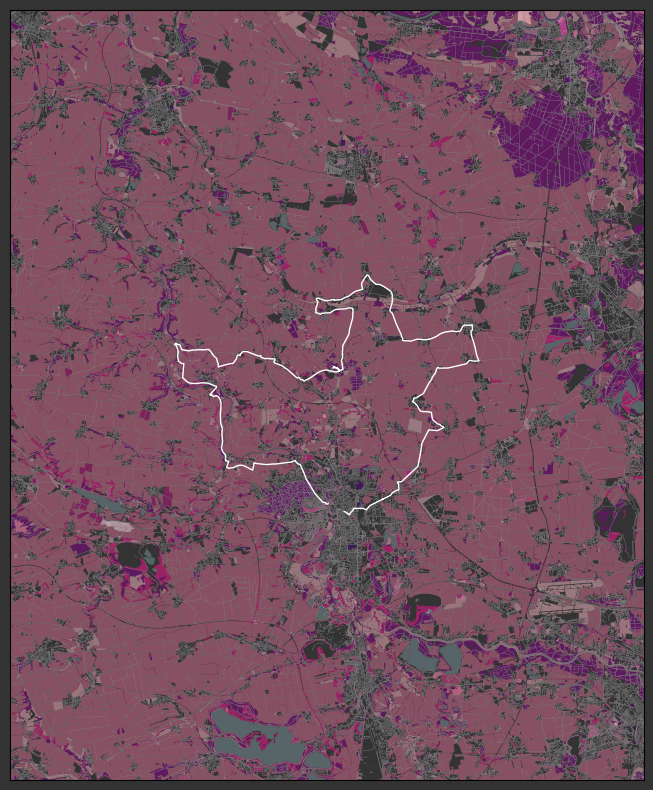

Bild gespeichert als: ../data/export/01_single_track_2025-04-19_18-38-16.png


In [42]:
# Montagsrunde

gpx_file_path = "../data/sample_gpx/VCA_SR.gpx"  # Ersetze mit deinem GPX-Dateipfad
water_path = "../data/plot_data/gis_osm_water_a_free_1.shp"  # Ersetze mit deinem Shapefile-Pfad
halle = gpd.read_file("../data/plot_data/halle.geojson")
osm_landuse = gpd.read_file("../data/plot_data/osm_landuse.geojson")

# Farbzuordnung für bestimmte fclass-Werte
color_map = {
    'grass':     '#ffc0cb',  # zartes Rosa (light pink)
    'meadow':    '#ffb6c1',  # etwas kräftigeres Rosa
    'park':      '#ff69b4',  # Hot Pink
    'scrub':     '#ff1493',  # Deep Pink
    'farmland':  '#db7093',  # Pale Violet Red
    'orchard':   '#c71585',  # Medium Violet Red
    'forest':    '#8b008b',  # Dark Magenta
    'vineyard':  '#800080',  # Purple
    'cemetery':  '#4b0082',  # Indigo
}

# Neue Spalte mit Farben – alle anderen werden NaN (unsichtbar)
osm_landuse['fill_color'] = osm_landuse['fclass'].map(color_map)

# Nur sichtbare Flächen behalten (nur definierte Farben)
osm_landuse_colored = osm_landuse[~osm_landuse['fill_color'].isna()]

#padding für Puffer um GPX definieren, Standart 0.01 - für quadratische Ausgabe höher wählen und dann zuschneiden
padding = 0.2
# Zusätzliches Shapefile z.B. Gewässer OSM laden
addShapefile = True

# GPX-Datei einlesen
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# GPX-Daten extrahieren (Latitude, Longitude, Zeit)
lats, lons, times = [], [], []

# Tracks und Segmente durchlaufen
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            times.append(point.time)

# Berechnung des Bounding-Boxes für den GPX-Track
north, south, east, west = max(lats), min(lats), max(lons), min(lons)
#padding = Puffer um den Track
north += padding
south -= padding
east += padding
west -= padding

# Bounding-Box erstellen
bbox = (west, south, east, north)  # (left, bottom, right, top)

# Herunterladen des Straßennetzes mit osmnx
G = ox.graph_from_bbox(
    bbox=bbox,
    network_type="bike",
    simplify=True,
    retain_all=True,
    truncate_by_edge=True,
)

# Kanten des Netzwerks extrahieren
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Distanz berechnen
distance_km = sum(
    geodesic((lats[i], lons[i]), (lats[i + 1], lons[i + 1])).km
    for i in range(len(lats) - 1)
)

# Visualisierung mit matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Straßennetz als Hintergrund zeichnen
edges.plot(ax=ax, linewidth=0.3, color="gray", alpha=0.5, zorder=2)

# GPX-Track zeichnen
ax.plot(lons, lats, color="white", linewidth=1, zorder=3)
#halle.plot(ax=ax, linewidth=1.5, color="#FF6984",linestyle='--', alpha=1, zorder=1)

if addShapefile:
    water = gpd.read_file(water_path)

    # Optional: Falls du bestimmte Farben und Stile für das Shapefile festlegen möchtest:
    #shapefile.plot(ax=ax, color="grey", alpha=1, linewidth=2, zorder=10)
    water.plot(ax=ax, color="lightblue", alpha=0.3, linewidth=2, zorder=1)

osm_landuse_colored.plot(ax=ax, color=osm_landuse_colored['fill_color'], edgecolor='none', linewidth=0.2, alpha=0.5, zorder=1)

# Hintergrund setzen
ax.set_facecolor("#333333")
fig.patch.set_facecolor("#333333")

# Achsen entfernen
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([west, east])
ax.set_ylim([south, north])

# Plot anzeigen
plt.show()

# Generiere den Zeitstempel im Format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


output_directory = "../data/export/"
output_filename = os.path.join(output_directory, f"01_single_track_{timestamp}.png")

# Speichern der Grafik mit dem neuen Dateinamen
fig.savefig(output_filename, dpi=1080, bbox_inches="tight", facecolor="black")
print(f"Bild gespeichert als: {output_filename}")

In [56]:
import matplotlib.pyplot as plt
import os
from datetime import datetime
import gpxpy
import geopandas as gpd
import osmnx as ox
from geopy.distance import geodesic
import random
from copy import deepcopy

# === Pfade ===
gpx_file_path = "../data/sample_gpx/VCA_FLINTA.gpx"
water_path = "../data/plot_data/gis_osm_water_a_free_1.shp"
halle = gpd.read_file("../data/plot_data/halle.geojson")
osm_landuse = gpd.read_file("../data/plot_data/osm_landuse.geojson")

# === Basis-Farbpalette ===
base_color_map = {
    'park': '#008026', 'meadow': '#ffed00', 'grass': '#55cdfc',
    'farmland': '#7902aa', 'forest': '#e40303', 'scrub': '#784f17',
    'orchard': '#f7a8b8', 'vineyard': '#732982', 'recreation_ground': '#24408E',
    'cemetery': '#000000', 'residential': '#ffffff', 'commercial': '#ffd800',
    'industrial': '#ff8c00', 'retail': '#732982', 'construction': '#f7a8b8',
    'allotments': '#55cdfc', 'garages': '#e40303', 'education': '#24408e',
    'institutional': '#ff8c00', 'military': '#000000', 'landfill': '#784f17',
    'quarry': '#ffd800', 'plant_nursery': '#008026', 'greenhouse_horticulture': '#ffed00',
    'basin': '#55cdfc', 'salt_pond': '#24408e', 'harbour': '#732982',
}
color_values = list(set(base_color_map.values()) - {'#ffffff'})

# === GPX-Datei laden ===
with open(gpx_file_path, "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

lats, lons = [], []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)

# === Bounding Box fixieren ===
padding = 0.08
north, south = max(lats) + padding, min(lats) - padding
east, west = max(lons) + padding, min(lons) - padding
bbox = (west, south, east, north)

# === OSM, Wasser und Straßennetz vorbereiten ===
G = ox.graph_from_bbox(bbox=bbox, network_type="bike", simplify=True, retain_all=True, truncate_by_edge=True)
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
#G = ox.graph_from_bbox(*bbox[::-1], network_type="bike", simplify=True, retain_all=True, truncate_by_edge=True)
#edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
water = gpd.read_file(water_path)

# === Ausgabeordner ===
output_directory = "../data/export/"
os.makedirs(output_directory, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# === Zentrale Plot-Funktion ===
def create_plot(filename, landuse_style="none", plot_water=False, landuse_color_map=None):
    fig, ax = plt.subplots(figsize=(10, 10))

    if landuse_style == "white":
        osm_landuse['fill_color'] = "#ffffff"
        osm_landuse_colored = osm_landuse
    elif landuse_style == "colored" and landuse_color_map:
        osm_landuse['fill_color'] = osm_landuse['fclass'].map(landuse_color_map)
        osm_landuse_colored = osm_landuse[~osm_landuse['fill_color'].isna()]
    else:
        osm_landuse_colored = None

    if landuse_colored := osm_landuse_colored is not None:
        osm_landuse_colored.plot(ax=ax, color=osm_landuse_colored['fill_color'], edgecolor='none', linewidth=0.2, alpha=0.4, zorder=1)

    if plot_water:
        water.plot(ax=ax, color="#24408E", alpha=0.4, linewidth=2, zorder=2)

    # Halle-Umring standardmäßig mitzeichnen
    halle.plot(ax=ax, color="black",alpha=0.4, linewidth=1, zorder=3)

    # Track doppelt für Kontrast
    ax.plot(lons, lats, color="white", linewidth=4, zorder=3)
    ax.plot(lons, lats, color="black", linestyle='-', linewidth=2, zorder=4)

    ax.set_facecolor("#ffffff")
    fig.patch.set_facecolor("#ffffff")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([west, east])
    ax.set_ylim([south, north])
    fig.savefig(filename, dpi=1080, bbox_inches="tight", facecolor="black")
    plt.close(fig)
    print(f"Gespeichert: {filename}")

# === Bild 1: Nur der Track ===
create_plot(
    filename=os.path.join(output_directory, f"01_track_only_{timestamp}.png"),
    landuse_style="white"
)

# === Bild 2: Landuse weiß + Wasser + Track ===
create_plot(
    filename=os.path.join(output_directory, f"02_track_water_white_landuse_{timestamp}.png"),
    landuse_style="white",
    plot_water=True
)

# === 10x Farbschema mit wechselnden Farben ===
for i in range(10):
    shuffled_colors = random.sample(color_values, len(color_values))
    temp_color_map = deepcopy(base_color_map)
    idx = 0
    for key in temp_color_map:
        if base_color_map[key] != '#ffffff':
            temp_color_map[key] = shuffled_colors[idx % len(shuffled_colors)]
            idx += 1

    create_plot(
        filename=os.path.join(output_directory, f"03_colored_variant_{i+1}_{timestamp}.png"),
        landuse_style="colored",
        plot_water=True,
        landuse_color_map=temp_color_map
    )


Gespeichert: ../data/export/01_track_only_2025-04-21_21-52-28.png
Gespeichert: ../data/export/02_track_water_white_landuse_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_1_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_2_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_3_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_4_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_5_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_6_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_7_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_8_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_9_2025-04-21_21-52-28.png
Gespeichert: ../data/export/03_colored_variant_10_2025-04-21_21-52-28.png
